# HW1 - Exploring MLPs with PyTorch

In [9]:
import torch
from torchvision import transforms, datasets
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import time

In [10]:
device = torch.device('cpu')

In [11]:
# define the data pre-processing
# convert the input to the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]
    )

# Load the MNIST dataset 
# this command requires Internet to download the dataset
mnist = datasets.MNIST(root='/Users/vashisth/Documents/GitHub/Intro_DL/IDL_hw1/data', 
                       train=True, 
                       download=True, 
                       transform=transform)
mnist_test = datasets.MNIST(root='/Users/vashisth/Documents/GitHub/Intro_DL/IDL_hw1/data',   # './data'
                            train=False, 
                            download=True, 
                            transform=transform)

In [12]:
from torch.utils.data import DataLoader, random_split

print("Frequencies: ", torch.bincount(mnist.targets))
print(len(torch.bincount(mnist.targets)))

Frequencies:  tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])
10


In [40]:
# Split training data into training and validation sets
# Your code goes here
# train_set = ...
# val_set = ...
train_len = int(len(mnist) *.8)
val_len = len(mnist) - train_len
train_set, val_set = random_split(mnist, [train_len, val_len])

# Define DataLoaders to access data in batches
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
# Your code goes here
val_loader = DataLoader(val_set, batch_size = 64, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size = 64, shuffle=False)

In [41]:
# Define your MLP
class RegressionMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(RegressionMLP, self).__init__()
        # Your code goes here
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.activation = nn.Tanh()

    def forward(self, x):
        # Your code goes here
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.activation(x)
        return x

# Your code goes here
hidden_dim = 50
model = RegressionMLP(in_dim=28 * 28,
                  hidden_dim=hidden_dim,
                  out_dim=28*28).to(device)
print(model)

RegressionMLP(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=784, bias=True)
  (activation): Tanh()
)


In [42]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [43]:
num_epochs = 20
start_time = time.time()
for epoch in range(num_epochs):
    correct, count = 0, 0 
    for data, target in train_loader:
        # free the gradient from the previous batch
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # reshape the image into a vector
        data = data.view(data.size(0), -1)
        # model forward
        output = model(data)
        # compute the loss
        loss = criterion(output, data)
        # model backward
        loss.backward()
        # update the model paramters
        optimizer.step()
       
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

training_time = time.time()- start_time
print(training_time)

Epoch 1, Loss: 0.0458
Epoch 2, Loss: 0.0329
Epoch 3, Loss: 0.0281
Epoch 4, Loss: 0.0268
Epoch 5, Loss: 0.0255
Epoch 6, Loss: 0.0226
Epoch 7, Loss: 0.0244
Epoch 8, Loss: 0.0245
Epoch 9, Loss: 0.0250
Epoch 10, Loss: 0.0205
Epoch 11, Loss: 0.0188
Epoch 12, Loss: 0.0195
Epoch 13, Loss: 0.0212
Epoch 14, Loss: 0.0229
Epoch 15, Loss: 0.0207
Epoch 16, Loss: 0.0212
Epoch 17, Loss: 0.0231
Epoch 18, Loss: 0.0259
Epoch 19, Loss: 0.0223
Epoch 20, Loss: 0.0189
54.57906413078308


In [44]:
val_loss = count = 0
correct = total = 0
for data, target in val_loader:
    data, target = data.to(device), target.to(device)
    data = data.view(data.size(0), -1)
    output = model(data)
    val_loss += criterion(output, data).item()
    count += 1

val_loss = val_loss / count
print(f'Validation loss: {val_loss:.2f}')

Validation loss: 0.02


In [45]:
model.eval()
loss = count= 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        output = model(data)
        loss += criterion(output, data).item()
        count +=1
        
test_loss= 100* loss/count
print(f'Test Loss: {test_loss:.2f}%')

Test Loss: 2.09%


In [62]:
from collections import defaultdict

In [91]:
original = []
reconstructed = []
labels = []
model.eval()
check_dict =defaultdict(list)
for data, target in test_loader:
    data = data.view(data.size(0), -1)
    output = model(data)
    output = output.detach().numpy()
    
    original.append(data)
    reconstructed.append(output)
    labels.append(target)
    
    for i in target:
        i = int(i)
        check_dict[i].append([data[i], output[i]])

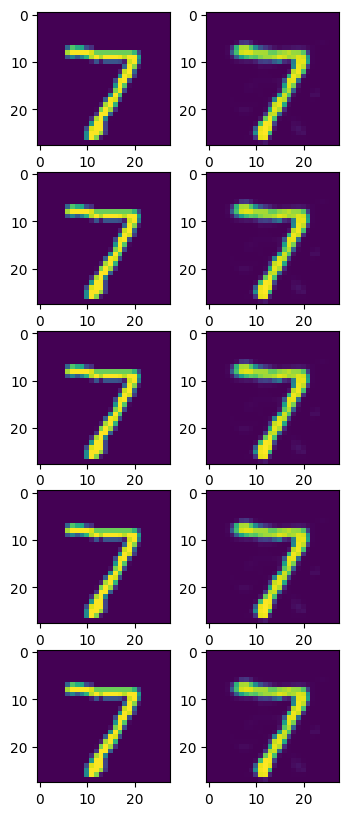

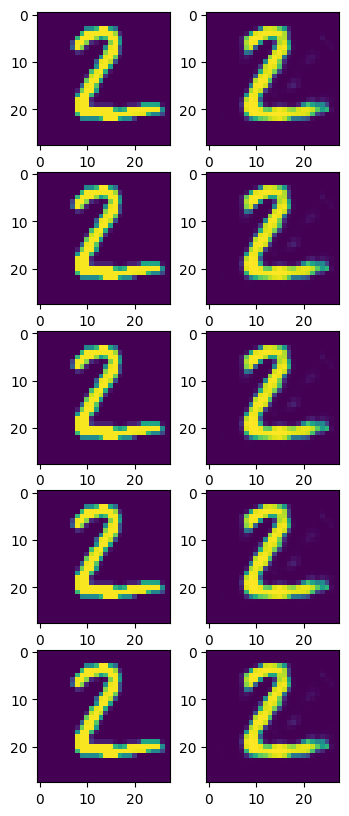

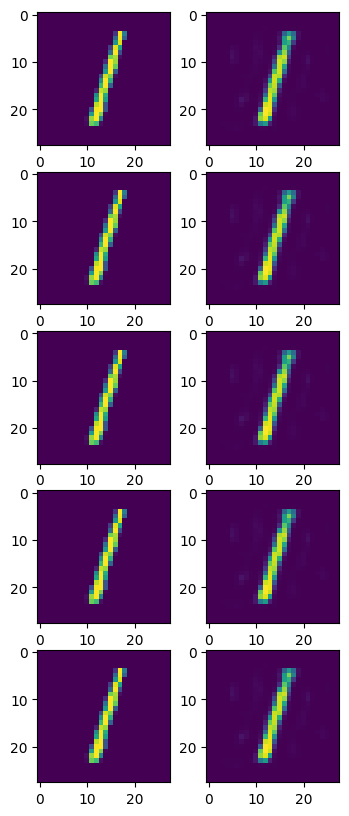

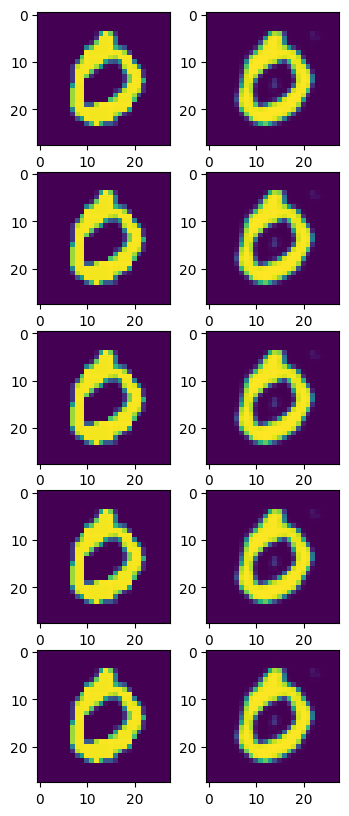

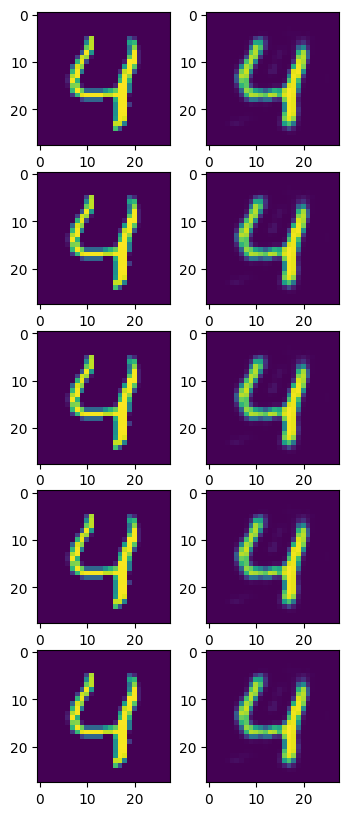

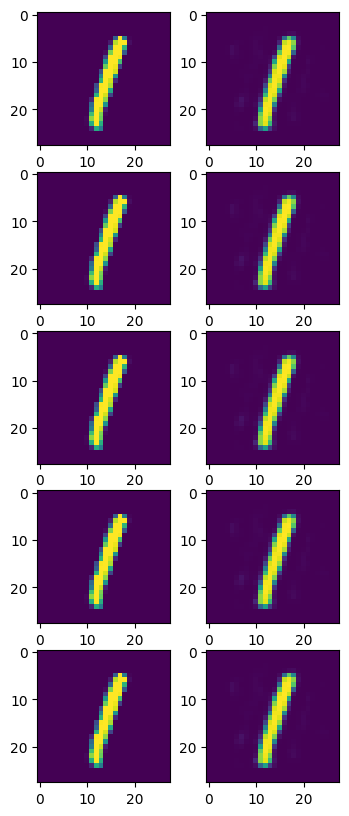

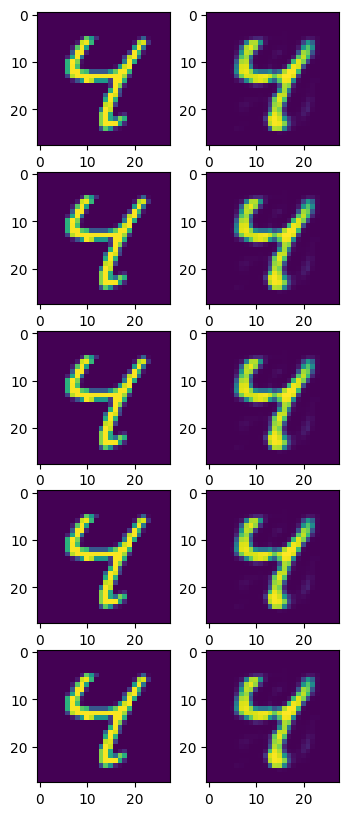

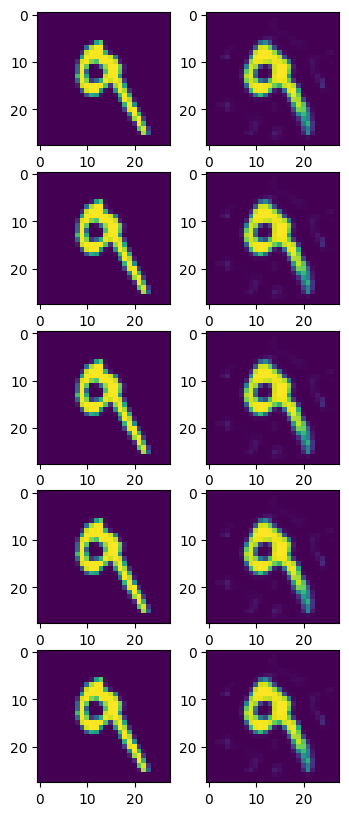

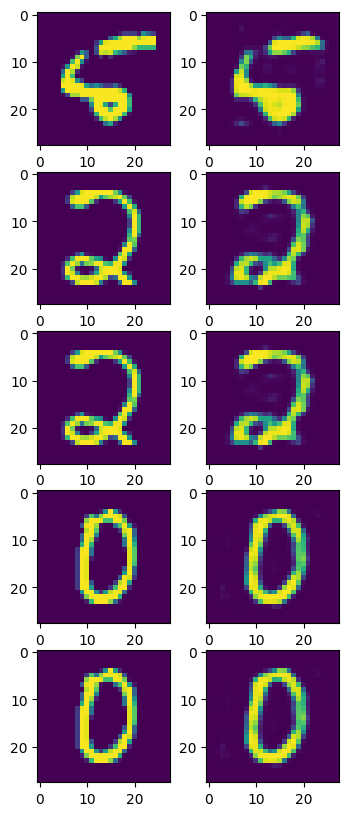

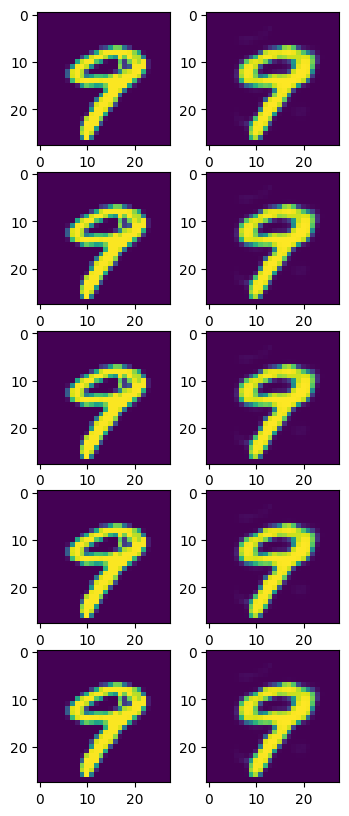

In [99]:
# https://stackoverflow.com/questions/55466298/pytorch-cant-call-numpy-on-variable-that-requires-grad-use-var-detach-num

#https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html

for i in range(len(check_dict.keys())):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(4,10))
    for j in range(5):
        axes[j,0].imshow(check_dict[i][j][0].reshape(28,28))
        axes[j,1].imshow(check_dict[i][j][1].reshape(28,28))


# Problem 4: Reconstruct the MNIST images by Regression
In this problem, we want to train the MLP (with only one hidden layer) to complete a regression task: reconstruct the input image. The goal of this task is dimension reduction, and we set the hidden layer dimension to a smaller number, say 50. Once we can train the MLP to reconstruct the input images perfectly, we find an lower dimension representation of the MNIST images.

Since this is a reconstruction task, the labels of the images are not needed, and the target is the same as the inputs. Mean Squared Error (MSE) is recommended as the loss function:

In [15]:
criterion = nn.MSELoss()

Another tip is to add a `torch.nn.Tanh()` activation layer to the end of the model. Recall that our data pre-processing converts the data into the range $[-1, 1]$:

In [16]:
# define the data pre-processing
# convert the input to the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]
    )

Having a `torch.nn.Tanh()` activation layer at the end of the model can convert the output of the model into the range $[-1, 1]$, making the training easier.

<span style="color:red">[YOUR TASK]</span>
- Define an MLP with only one hidden layer and set the hidden layer dimension as 50. Train the MLP to reconstruct input images from all 10 digits.
- Report the Mean Squared Error on the training, validation and test set. Report your hyper-parameter details.
- Pick 5 images for each digit from the test set. Visualize the original images and the reconstructed images using the MLP.

In [17]:
# Your code goes here